## Train Fashion MNIST Data with Pytorch

In [ ]:
#import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#Data Import, Preparation and Preprocessing, Transformation Pipeline
#Define transformation for training and testing set
transform = transforms.Compose([
    transforms.ToTensor(),     #Convert input images to pytorch tensor
    transforms.Normalize((0.5,), (0.5,))    #Normalize the data to [-1, 1]
])

In [ ]:
#Download and Load the training dataset
trainset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset,           #Dataset to load
    batch_size=64,      #Number of sample per batch
    shuffle=True        #Shuffle the data at every epoch
)

In [ ]:
#Download and load the testing dataset
testset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform

)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=64,
    shuffle=False
)


In [ ]:
#Understanding the data Map neumaric labels to class names
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#Function to show an image
def imshow(img):
  img = img/2 + 0.5 #Unnormalize the image
  npimg = img.numpy()
  plt.imshow(np.squeeze(npimg), cmap='gray')
  plt.axis('off')
  plt.show()

#Gets some random training image
dataiter = iter(trainloader)
images, labels = next(dataiter)
images

tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -0.1137, -1.0000, -0.9922],
          [-1.0000, -1.0000, -1.0000,  ...,  0.0588, -1.0000, -1.0000],
          ...,
          [-1.0000, -0.8431,  0.5529,  ..., -0.9922, -1.0000, -1.0000],
          [-1.0000, -0.8196, -0.7725,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.000

In [ ]:
len(labels)

64

In [ ]:
labels

tensor([8, 0, 5, 3, 7, 8, 4, 1, 0, 0, 2, 3, 9, 0, 4, 3, 0, 0, 8, 3, 5, 5, 6, 7,
        6, 7, 1, 3, 7, 4, 1, 7, 6, 2, 9, 0, 5, 2, 0, 0, 3, 2, 9, 5, 5, 5, 0, 2,
        5, 0, 1, 2, 7, 6, 1, 8, 4, 3, 4, 5, 2, 9, 0, 2])

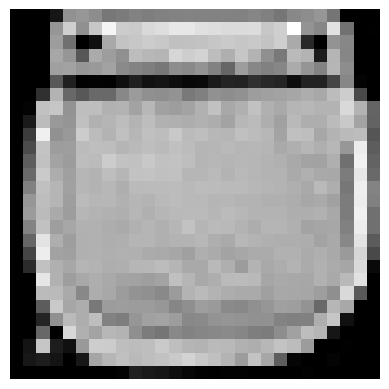

Label:  Bag


In [ ]:
#Show an image
imshow(images[0])
print("Label: ",classes[labels[0]])

### Defining Neural Network with Dropout Layer

In [ ]:
class NetWithDropout(nn.Module):
  def __init__(self):
    super(NetWithDropout, self).__init__()

    self.fc1 = nn.Linear(28*28, 256)
    self.dropout1 = nn.Dropout(0.5)
    self.relu1 = nn.ReLU()

    self.fc2 = nn.Linear(256, 128)
    self.dropout2 = nn.Dropout(0.5)
    self.relu2 = nn.ReLU()

    self.fc3 = nn.Linear(128, 64)
    self.dropout3 = nn.Dropout(0.5)
    self.relu3 = nn.ReLU()

    self.fc4 = nn.Linear(64, 10)      #Output Layer with 10 classes

  def forward(self, x):
    x = x.view(-1, 28*28)         #Flatten the image
    x = self.dropout1(self.relu1(self.fc1(x)))
    x = self.dropout2(self.relu2(self.fc2(x)))
    x = self.dropout3(self.relu3(self.fc3(x)))

    x = self.fc4(x)       #Output layer(no activation, use crossentropy loss)

    return x

#Initialize the network with dropout
net = NetWithDropout()

#Choose loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

In [ ]:
#Training Parameters and Variable
num_epochs = 10
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 3      #Early stopping patience
trigger_times = 0

#Training loop with early stopping
for epoch in range(num_epochs):
  net.train()       #Set the model into training mode
  running_train_loss = 0.0
  for inputs, labels in trainloader:
    optimizer.zero_grad()     #Set Zero the parameter gradients of the model
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()       #Backward Pass
    optimizer.step()      #Update the weights
    running_train_loss += loss.item()     #retrieve the scaler value of the loss tensor
  train_loss = running_train_loss / len(trainloader)
  train_losses.append(train_loss)

  net.eval()    #Set the model into evaluation mode
  running_val_loss = 0.0
  with torch.no_grad():    # Make sure no gradients are computed or stored.
    for inputs, labels in testloader:
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      running_val_loss += loss.item()     #retrieve the scaler value of the loss tensor
  val_loss = running_val_loss / len(testloader)
  val_losses.append(val_loss)
  print(f'Epoch [{epoch + 1} / {num_epochs}], Training Loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}')

  #Early Stopping
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    trigger_times = 0
    #Save the model checkpoint
    torch.save(net.state_dict(), 'best_model.pth')
  else:
    trigger_times += 1
    if trigger_times >= patience:
      print(f'Early stopping at epoch {epoch + 1}')
      break


Epoch [1 / 10], Training Loss: 0.5119, Validation loss: 0.4116
Epoch [2 / 10], Training Loss: 0.5133, Validation loss: 0.4142
Epoch [3 / 10], Training Loss: 0.5183, Validation loss: 0.4291
Epoch [4 / 10], Training Loss: 0.5120, Validation loss: 0.4065
Epoch [5 / 10], Training Loss: 0.5148, Validation loss: 0.4192
Epoch [6 / 10], Training Loss: 0.5114, Validation loss: 0.4082
Epoch [7 / 10], Training Loss: 0.5090, Validation loss: 0.4144
Early stopping at epoch 7


In [ ]:
#Loading the best model
net.load_state_dict(torch.load('best_model.pth'))

<ipython-input-26-2f2aa681c5b8>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

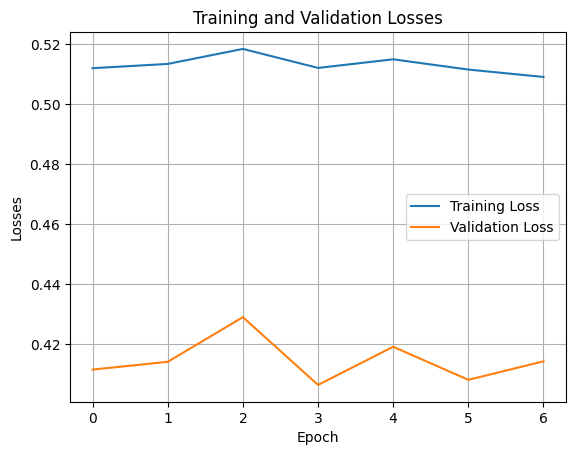

In [ ]:
#Plotting the losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Evaluating Final Model
def evaluate_network():
  net.eval()
  correct = 0
  total = 0
  class_correct = [0] * 10
  class_total = [0] * 10
  with torch.no_grad():
    for inputs, labels in testloader:
      outputs = net(inputs)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      # Per-class accuracy
      c = (predicted == labels).squeeze()
      for i in range(len(labels)):
          label = labels[i]
          class_correct[label] += c[i].item()
          class_total[label] += 1

  print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
  # Print accuracy for each class
  for i in range(10):
      if class_total[i] > 0:
          print(f'Accuracy of {classes[i]:>10s}: {100 * class_correct[i] / class_total[i]:.2f}%')
      else:
          print(f'Accuracy of {classes[i]:>10s}: N/A (no samples)')
  # Call the evaluation function
  evaluate_network()

### Create the scenario of exploding gradient decent and implement gradient clipping

In [ ]:
#import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#Data Import, preparation and preprocessing
#Define transformation pipeline for the training and testing set
transform = transforms.Compose([
    transforms.ToTensor(),                 #Converts image into pytorch tensor and scale the image from [0, 255] to [0, 1]
    transforms.Normalize((0.5,), (0.5,))  #Normalize the data to [-1, 1]
])

In [ ]:
#Download and load the training data
trainset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=64,
    shuffle=True
)
#Download and load the testing data
testset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=64,
    shuffle=False
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.77MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 176kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.31MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.00MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
#Map numeric labels to class names
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#Defining Neural Network
class SimpleNet(nn.Module):
  def __init__(self):
    super(SimpleNet, self).__init__()

    self.fc1 = nn.Linear(28*28, 512)
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(512, 256)
    self.relu2 = nn.ReLU()
    self.fc3 = nn.Linear(256, 128)
    self.relu3 = nn.ReLU()
    self.fc4 = nn.Linear(128, 64)
    self.relu4 = nn.ReLU()
    self.fc5 = nn.Linear(64, 10)    #Output Layer for 10 classes

  def forward(self, x):
    x = x.view(-1, 28*28)
    x = self.relu1(self.fc1(x))
    x = self.relu2(self.fc2(x))
    x = self.relu3(self.fc3(x))
    x = self.relu4(self.fc4(x))
    x = self.fc5(x)
    return x


In [ ]:
#Demonstrating the exploding gradient problem
def train_without_clipping(net, optimizer, criterion, num_epochs=5):
  print("\nTraining without Clipping")
  net.train()

  train_losses = []
  for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
      optimizer.zero_grad()
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()   #retrieve the scaler value of loss tensor
    epoch_loss = running_loss / len(trainloader)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch + 1} / {num_epochs}], Loss: {epoch_loss:.4f}')

  print('Finished Training without Clipping')
  return train_losses


Training without Clipping
Epoch [1 / 5], Loss: nan
Epoch [2 / 5], Loss: nan
Epoch [3 / 5], Loss: nan
Epoch [4 / 5], Loss: nan
Epoch [5 / 5], Loss: nan
Finished Training without Clipping


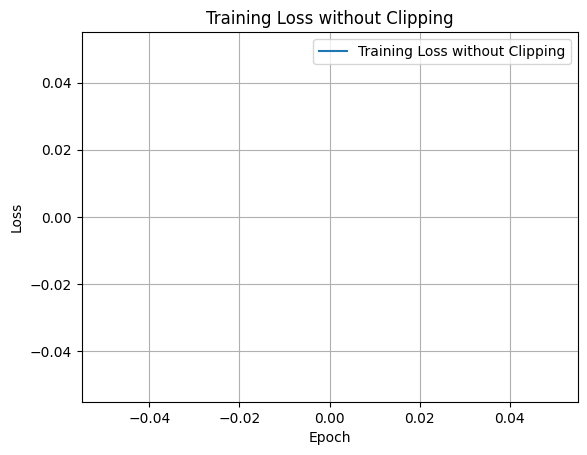

In [ ]:
#Initialize the network
net = SimpleNet()
#Define optimizer and loss function with high learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1.0)   #High Learning Rate
#Train the Network
train_losses_without_clipping = train_without_clipping(net, optimizer, criterion)

#Plot the training losses
plt.plot(train_losses_without_clipping, label='Training Loss without Clipping')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss without Clipping')
plt.legend()
plt.grid(True)
plt.show()


Training with Gradient Clipping
Epoch [1 / 5], Loss: 0.7946
Epoch [2 / 5], Loss: 0.5105
Epoch [3 / 5], Loss: 0.4475
Epoch [4 / 5], Loss: 0.4192
Epoch [5 / 5], Loss: 0.3964
Finished Training with Gradient Clipping


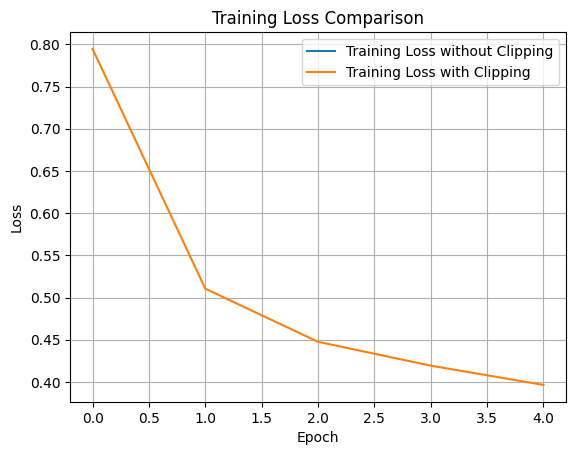

In [ ]:
#Solving Exploding Gradient Problem
def train_with_clipping(net, optimizer, criterion, clip_value=1.0, num_epochs=5):
  print("\nTraining with Gradient Clipping")
  net.train()

  train_losses = []
  for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
      optimizer.zero_grad()
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      #Apply Gradient Clipping
      torch.nn.utils.clip_grad_norm_(net.parameters(), clip_value)
      optimizer.step()
      running_loss += loss.item()
    epoch_loss = running_loss / len(trainloader)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch + 1} / {num_epochs}], Loss: {epoch_loss:.4f}')

  print('Finished Training with Gradient Clipping')
  return train_losses


#Reinitialized the Network
net_clipped = SimpleNet()
#Define the loss function and optimizer with the same high learning rate
criterion_clipped = nn.CrossEntropyLoss()
optimizer_clipped = optim.SGD(net_clipped.parameters(), lr=1.0)

#Train the network with Gradient Clipping
losses_with_clipping = train_with_clipping(net_clipped, optimizer_clipped, criterion_clipped, clip_value=1.0, num_epochs=5)

#Plot the training Loss
plt.figure()
plt.plot(train_losses_without_clipping, label='Training Loss without Clipping')
plt.plot(losses_with_clipping, label='Training Loss with Clipping')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Evaluate the model trained with Gradient Clipping
def evaluate_model(net):
  net.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for inputs, labels in testloader:
      outputs = net(inputs)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  print(f'Accuracy on the test set: {100 * correct / total:.2f}%')


#Evaluate the model training without clipping
print("\nEvaluating model trained without gradient clipping (may fail due to NaNs):")
evaluate_model(net)

# Evaluate the model trained with clipping
print("\nEvaluating model trained with gradient clipping:")
evaluate_model(net_clipped)


Evaluating model trained without gradient clipping (may fail due to NaNs):
Accuracy on the test set: 10.00%

Evaluating model trained with gradient clipping:
Accuracy on the test set: 82.14%


### Experiment with Adam Optimizer

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 1. Data Import, Preparation, and Preprocessing

# Define transformations for the training and testing sets
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the data to [-1, 1]
])

# Download and load the training data
trainset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=64,
    shuffle=True
)

# Download and load the testing data
testset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=64,
    shuffle=False
)

# Map numeric labels to class names
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 2. Defining the Neural Network

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 128)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(128, 64)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(64, 10)  # Output layer

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.relu4(self.fc4(x))
        x = self.fc5(x)
        return x


Training with Adam Optimizer
Epoch [1 / 5], Loss: 0.5342
Epoch [2 / 5], Loss: 0.3847
Epoch [3 / 5], Loss: 0.3408
Epoch [4 / 5], Loss: 0.3148
Epoch [5 / 5], Loss: 0.2933

Finished Training with Optimizer Adam


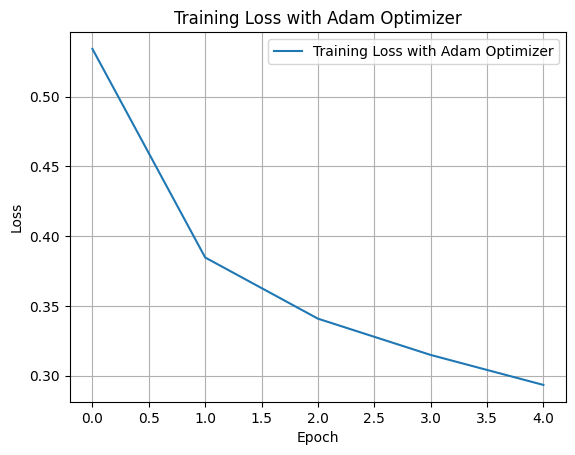

In [ ]:
#Training Function without Gradient Clipping (Adam Optimizer)
def train_with_optimizer(net, optimizer, criterion, num_epochs=5):
  print('\nTraining with Adam Optimizer')
  net.train()
  train_losses = []
  for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in trainloader:
      optimizer.zero_grad()
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    epoch_loss = running_loss / len(trainloader)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch + 1} / {num_epochs}], Loss: {epoch_loss:.4f}')
  print("\nFinished Training with Optimizer Adam")
  return train_losses

#Initialize the network
net = SimpleNet()
#Define Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001) #Adam Optimizer

#Train the network
losses_with_optimizer = train_with_optimizer(net, optimizer, criterion, num_epochs=5)
# Plot the training losses
plt.figure()
plt.plot(losses_with_optimizer, label='Training Loss with Adam Optimizer')
plt.title('Training Loss with Adam Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 4. Evaluating the Model Trained with Adam Optimizer

def evaluate_model(net):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy on the test set: {100 * correct / total:.2f}%')

# Evaluate the model
print("\nEvaluating model trained with Adam optimizer:")
evaluate_model(net)#


Evaluating model trained with Adam optimizer:
Accuracy on the test set: 87.27%


### Implementation of L1, L2 Regularization with Optimizer

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 1. Data Import, Preparation, and Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


Training with L2 Regularization
Epoch [1/5], Loss: 0.5550
Epoch [2/5], Loss: 0.4274
Epoch [3/5], Loss: 0.3935
Epoch [4/5], Loss: 0.3730
Epoch [5/5], Loss: 0.3553

Train the model with L2 regularization


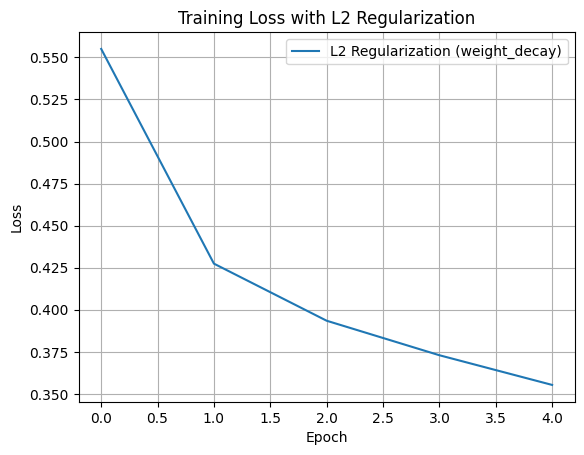

In [ ]:
#Defining the Neural Network
class SimpleNet(nn.Module):
  def __init__(self):
    super(SimpleNet, self).__init__()

    self.fc1 = nn.Linear(28*28, 512)    #Input size is 28*28 and transform it into 512 unit
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 128)
    self.fc4 = nn.Linear(128, 64)
    self.fc5 = nn.Linear(64, 10)

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    x = self.fc5(x)
    return x

#Initialize the network
net = SimpleNet()
#Define the loss function
criterion = nn.CrossEntropyLoss()
#L2 Regularization using weight decay in the optimizer
optimizer_l2 = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)  #L2 Regularization

#Function for training L2 Regularization (via weight decay)
def train_with_l2_regularization(net, optimizer, criterion, num_epochs=5):
  print("\nTraining with L2 Regularization")
  train_losses = []
  for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        optimizer.zero_grad()         # Zero gradients
        outputs = net(inputs)         # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()               # Backpropagation
        optimizer.step()              # Update weights
        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")
  print("\nTrain the model with L2 regularization")
  return train_losses

# Train the model with L2 regularization
train_losses_l2 = train_with_l2_regularization(net, optimizer_l2, criterion, num_epochs=5)

# Plot the training loss for L2 regularization
plt.figure()
plt.plot(train_losses_l2, label='L2 Regularization (weight_decay)')
plt.title('Training Loss with L2 Regularization')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 4. L1 Regularization Implementation (Manually Adding L1 to Loss)
l1_lambda = 0.01    #The strength of L1 Regularization

# Function for training with manual L1 regularization
def train_with_l1_regularization(net, optimizer, criterion, l1_lambda, num_epochs=5):
    print("\nTraining with L1 Regularization")
    train_losses = []

    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()         # Zero gradients
            outputs = net(inputs)         # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            # Manually add L1 regularization (sum of absolute values of weights)
            l1_norm = sum(p.abs().sum() for p in net.parameters())
            loss = loss + l1_lambda * l1_norm  # Add L1 penalty to the loss

            loss.backward()               # Backpropagation
            optimizer.step()              # Update weights
            running_loss += loss.item()

        epoch_loss = running_loss / len(trainloader)
        train_losses.append(epoch_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    return train_losses


Training with L1 Regularization
Epoch [1/5], Loss: 4.9696
Epoch [2/5], Loss: 3.0177
Epoch [3/5], Loss: 3.0177
Epoch [4/5], Loss: 3.0178
Epoch [5/5], Loss: 3.0177


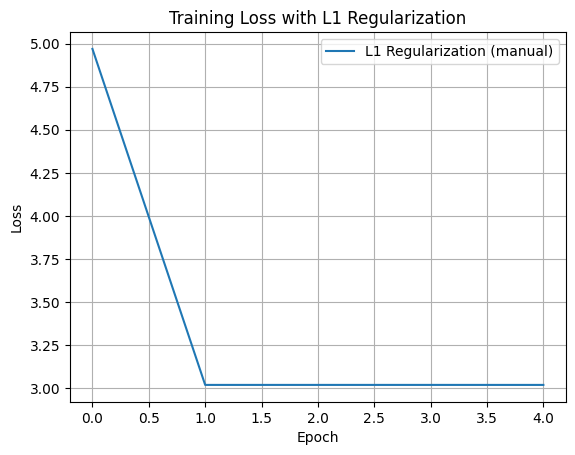

In [ ]:
# Reinitialize the network for L1 training
net_l1 = SimpleNet()

# Define the optimizer without weight_decay for L1 (since we'll add L1 manually)
optimizer_l1 = optim.Adam(net_l1.parameters(), lr=0.001)

# Train the model with L1 regularization
train_losses_l1 = train_with_l1_regularization(net_l1, optimizer_l1, criterion, l1_lambda, num_epochs=5)

# Plot the training loss for L1 regularization
plt.figure()
plt.plot(train_losses_l1, label='L1 Regularization (manual)')
plt.title('Training Loss with L1 Regularization')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 5. Model Evaluation
def evaluate_model(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / total:.2f}%')

# Evaluate the model trained with L2 regularization
print("\nEvaluating model trained with L2 regularization:")
evaluate_model(net, testloader)

# Evaluate the model trained with L1 regularization
print("\nEvaluating model trained with L1 regularization:")
evaluate_model(net_l1, testloader)


Evaluating model trained with L2 regularization:
Accuracy: 85.54%

Evaluating model trained with L1 regularization:
Accuracy: 10.00%
